In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Enron Network
# Each line represents an email: "sender recipient"
df_edgelist = pd.read_csv('/content/drive/MyDrive/Hng tasks/Hng task 7/Email-Enron-edited.csv',)
df_edgelist

sender  recipient
0            0          1
1            1          0
2            1          2
3            1          3
4            1          4
...        ...        ...
367657   36688      36686
367658   36688      36687
367659   36689      36690
367660   36690      36689
367661   36691       8203

[367662 rows x 2 columns]

In [ ]:
G = nx.from_pandas_edgelist(df_edgelist, source='sender', target='recipient')

In [ ]:
# Count the number of times each sender-receiver pair appears
edge_weights = df_edgelist.groupby(['sender', 'recipient']).size().reset_index(name='weight')

# Merge weights back into the DataFrame (optional, but useful)
df_edgelist_weighted = df_edgelist.merge(edge_weights, on=['sender', 'recipient'], how='left').fillna(1)  # Fill NaN weights with 1 (if needed)

print(df_edgelist_weighted)

        sender  recipient  weight
0            0          1       1
1            1          0       1
2            1          2       1
3            1          3       1
4            1          4       1
...        ...        ...     ...
367657   36688      36686       1
367658   36688      36687       1
367659   36689      36690       1
367660   36690      36689       1
367661   36691       8203       1

[367662 rows x 3 columns]


In [ ]:
#Basic Network Statistics:*
  #Calculate basic metrics like the number of nodes, edges, average degree, etc.
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values()) / G.number_of_nodes())

Number of nodes: 36692
Number of edges: 183831
Average degree: 10.020222391802028


In [ ]:
# Create a directed weighted graph from the DataFrame
G_weighted = nx.from_pandas_edgelist(df_edgelist_weighted, source='sender', target='recipient',
                                     edge_attr='weight', create_using=nx.DiGraph())

# Now G_weighted is a NetworkX DiGraph where each edge has a 'weight' attribute.
print(G_weighted.edges(data=True))

In [ ]:
#Basic Network Statistics:*
  #Calculate basic metrics like the number of nodes, edges, average degree, etc.
print("Number of nodes:", G_weighted.number_of_nodes())
print("Number of edges:", G_weighted.number_of_edges())
print("Average degree:", sum(dict(G_weighted.degree()).values()) / G_weighted.number_of_nodes())

Number of nodes: 36692
Number of edges: 367662
Average degree: 20.040444783604055


In [ ]:
##sample size of top 5% to reduce load time
def sample_top_5_percent_by_out_degree(G_weighted):
    """
    Samples the top 5% of nodes based on their out-degree.

    Args:
        G (nx.DiGraph): The directed graph.

    Returns:
        nx.DiGraph: A subgraph containing the top 5% of nodes by out-degree.
    """

    # 1. Calculate Out-Degrees
    out_degrees = dict(G_weighted.out_degree())

    # 2. Sort Nodes by Out-Degree
    sorted_nodes = sorted(out_degrees.items(), key=lambda item: item[1], reverse=True)
    nodes = [node for node, degree in sorted_nodes]

    # 3. Determine the Number of Nodes for 5%
    num_top_nodes = int(len(nodes * 0.05)  # Get the top 5%

    # 4. Select the Top 5% Nodes
    top_5_percent_nodes = nodes[:num_top_nodes]

    # 5. Create Subgraph
    subgraph = G_weighted.subgraph(top_5_percent_nodes)

    return subgraph

top_5_percent_subgraph = sample_top_5_percent_by_out_degree(G_weighted)
print("Number of nodes in the subgraph:", top_5_percent_subgraph.number_of_nodes())
print("Number of edges in the subgraph:", top_5_percent_subgraph.number_of_edges())

Number of nodes in the subgraph: 1834
Number of edges in the subgraph: 112396


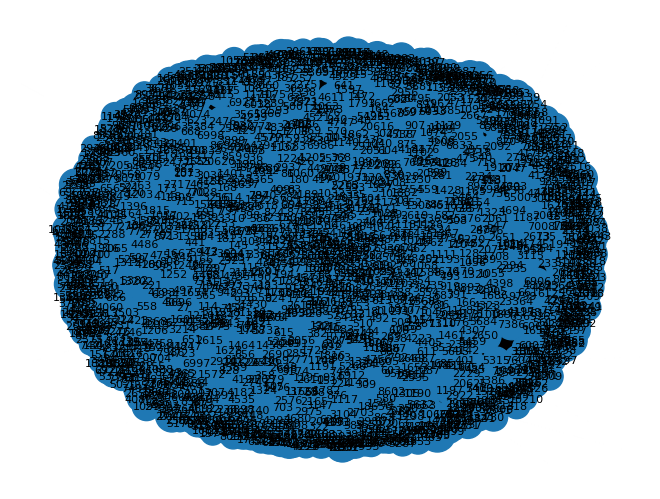

In [ ]:
# Adjust the layout algorithm:
pos = nx.spring_layout(top_5_percent_subgraph, k=1)  # Increased k for spacing

# Scale node sizes based on out-degree for better visualization:
node_sizes = [top_5_percent_subgraph.out_degree(node) * 10 for node in top_5_percent_subgraph.nodes()]

#Draw the subgraph with adjusted parameters:
nx.draw(top_5_percent_subgraph, pos=pos, with_labels=True, node_size=node_sizes, font_size=8)
plt.show() ##visualize top_5_percent

In [ ]:
# Calculate weighted degree centrality
weighted_degree_centrality = nx.degree(G_weighted, weight='weight')

# Normalize by dividing by the maximum possible degree (n-1)
n = G_weighted.number_of_nodes()
weighted_degree_centrality = {node: degree / (n - 1) for node, degree in weighted_degree_centrality}

print("Weighted Degree Centrality:", weighted_degree_centrality)

Weighted Degree Centrality: {0: 5.450928020495489e-05, 1: 0.0038156496143468424, 2: 5.450928020495489e-05, 3: 0.00027254640102477445, 4: 0.0004360742416396391, 5: 0.0033795753727072033, 6: 0.0004905835218445941, 7: 0.0007631299228693685, 8: 5.450928020495489e-05, 9: 0.002125861927993241, 10: 0.00021803712081981956, 11: 0.00027254640102477445, 12: 0.00027254640102477445, 13: 0.0008176392030743234, 14: 5.450928020495489e-05, 15: 0.00032705568122972934, 16: 0.00027254640102477445, 17: 5.450928020495489e-05, 18: 0.00027254640102477445, 19: 0.00016352784061486467, 20: 5.450928020495489e-05, 21: 0.00021803712081981956, 22: 5.450928020495489e-05, 23: 5.450928020495489e-05, 24: 5.450928020495489e-05, 25: 0.00010901856040990978, 26: 5.450928020495489e-05, 27: 0.004251723855986482, 28: 5.450928020495489e-05, 29: 5.450928020495489e-05, 30: 0.00010901856040990978, 31: 0.00016352784061486467, 32: 0.00010901856040990978, 33: 5.450928020495489e-05, 34: 5.450928020495489e-05, 35: 0.0001635278406148646

In [ ]:
# Identifying Influential Internal "Salespeople"
def identify_influential_senders(G_weighted, top_n=10):
    """Identifies the most influential senders based on out-degree centrality."""
    out_degree_centrality = dict(G_weighted.out_degree())  # Get out-degree for each node
    sorted_senders = sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True)
    return sorted_senders[:top_n]

influential_senders = identify_influential_senders(G_weighted)
print("Influential Senders (Out-Degree):", influential_senders)
# Relate to outbound sales: High out-degree suggests individuals who initiate a lot of communication,
# similar to outbound sales efforts.

Influential Senders (Out-Degree): [(5038, 1383), (273, 1367), (458, 1261), (140, 1245), (1028, 1244), (195, 1143), (370, 1099), (1139, 1068), (136, 1026), (566, 924)]


In [ ]:
import numpy as np

# G_weighted-directed graph (nx.DiGraph)

out_degrees = [G_weighted.out_degree(node) for node in G_weighted.nodes()]
in_degrees = [G_weighted.in_degree(node) for node in G_weighted.nodes()]

# Calculate statistics
avg_out_degree = np.mean(out_degrees)
std_out_degree = np.std(out_degrees)
median_out_degree = np.median(out_degrees)
max_out_degree = max(in_degrees)

avg_in_degree = np.mean(in_degrees)
std_in_degree = np.std(in_degrees)
median_in_degree = np.median(in_degrees)
max_in_degree = max(out_degrees)

print("Out-Degree Statistics:")
print(f"  Average: {avg_out_degree}")
print(f"  Standard Deviation: {std_out_degree}")
print(f"  Median: {median_out_degree}")
print(f"  Max: {max_out_degree}")

print("\nIn-Degree Statistics:")
print(f"  Average: {avg_in_degree}")
print(f"  Standard Deviation: {std_in_degree}")
print(f"  Median: {median_in_degree}")
print(f" Max: {max_in_degree}")

Out-Degree Statistics:
  Average: 10.020222391802028
  Standard Deviation: 36.100004407047514
  Median: 3.0
  Max: 1383

In-Degree Statistics:
  Average: 10.020222391802028
  Standard Deviation: 36.100004407047514
  Median: 3.0
 Max: 1383


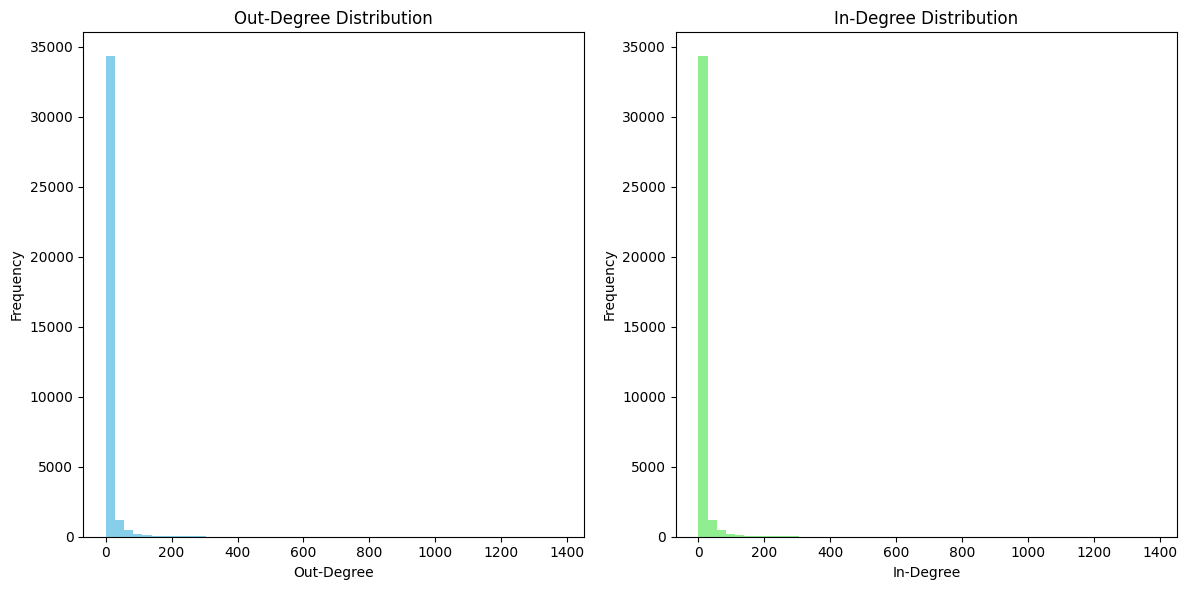

In [ ]:
import matplotlib.pyplot as plt

# where G_weighted is your directed graph (nx.DiGraph)

out_degrees = [G_weighted.out_degree(node) for node in G_weighted.nodes()]
in_degrees = [G_weighted.in_degree(node) for node in G_weighted.nodes()]

# Plot out-degree distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create two subplots side-by-side
plt.hist(out_degrees, bins=50, color='skyblue')  # Adjust bins as needed
plt.xlabel("Out-Degree")
plt.ylabel("Frequency")
plt.title("Out-Degree Distribution")

# Plot in-degree distribution
plt.subplot(1, 2, 2)
plt.hist(in_degrees, bins=50, color='lightgreen')
plt.xlabel("In-Degree")
plt.ylabel("Frequency")
plt.title("In-Degree Distribution")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
def identify_source_nodes(G_weighted):
    """Identifies source nodes based on out-degree and in-degree."""
    source_nodes = []
    for node in G_weighted.nodes():
        out_degree = G_weighted.out_degree(node)
        in_degree = G_weighted.in_degree(node)
        print(f"Node: {node}, Out-degree: {out_degree}, In-degree: {in_degree}")  # Debugging line
        out_degree_threshold = 100 # Example threshold for high out-degree
        in_degree_threshold = 100 # Example threshold for low in-degree

        if out_degree > out_degree_threshold and in_degree < in_degree_threshold:
            source_nodes.append(node)

    return source_nodes

source_nodes = identify_source_nodes(G_weighted)
print("Source Nodes:", source_nodes)

Node: 0, Out-degree: 1, In-degree: 1
Node: 1, Out-degree: 70, In-degree: 70
Node: 2, Out-degree: 1, In-degree: 1
Node: 3, Out-degree: 5, In-degree: 5
Node: 4, Out-degree: 8, In-degree: 8
Node: 5, Out-degree: 62, In-degree: 62
Node: 6, Out-degree: 9, In-degree: 9
Node: 7, Out-degree: 14, In-degree: 14
Node: 8, Out-degree: 1, In-degree: 1
Node: 9, Out-degree: 39, In-degree: 39
Node: 10, Out-degree: 4, In-degree: 4
Node: 11, Out-degree: 5, In-degree: 5
Node: 12, Out-degree: 5, In-degree: 5
Node: 13, Out-degree: 15, In-degree: 15
Node: 14, Out-degree: 1, In-degree: 1
Node: 15, Out-degree: 6, In-degree: 6
Node: 16, Out-degree: 5, In-degree: 5
Node: 17, Out-degree: 1, In-degree: 1
Node: 18, Out-degree: 5, In-degree: 5
Node: 19, Out-degree: 3, In-degree: 3
Node: 20, Out-degree: 1, In-degree: 1
Node: 21, Out-degree: 4, In-degree: 4
Node: 22, Out-degree: 1, In-degree: 1
Node: 23, Out-degree: 1, In-degree: 1
Node: 24, Out-degree: 1, In-degree: 1
Node: 25, Out-degree: 2, In-degree: 2
Node: 26, Ou

In [ ]:
# 1. Information Diffusion for "Deals/Projects"
# (This requires additional data on "deals/projects" associated with emails.
#  For simplicity, let's analyze general information flow using shortest paths)
def analyze_information_flow(G_weighted, source_node, top_n=5):
    """Analyzes information flow from a source node using shortest path lengths."""
    shortest_paths = nx.shortest_path_length(G_weighted, source=source_node)
    sorted_paths = sorted(shortest_paths.items(), key=lambda item: item[1])
    return sorted_paths[:top_n]

# Choose a source node for analysis
source_node = 5038
info_flow_from_5038  = analyze_information_flow(G_weighted, source_node) # Pass the source_node to the function
print("Shortest Path:", info_flow_from_5038)
# Relate to outbound campaigns: Shortest paths indicate how quickly information can spread.

Shortest Path: [(5038, 0), (46, 1), (292, 1), (566, 1), (588, 1)]


In [ ]:
# 1. Information Diffusion for "Deals/Projects"
# (This requires additional data on "deals/projects" associated with emails.
#  For simplicity, let's analyze general information flow using shortest paths)
def analyze_information_flow(G_weighted, source_node, top_n=5):
    """Analyzes information flow from a source node using shortest path lengths."""
    shortest_paths = nx.shortest_path_length(G_weighted, source=source_node)
    sorted_paths = sorted(shortest_paths.items(), key=lambda item: item[1])
    return sorted_paths[:top_n]

# Choose a source node for analysis
source_node = 1383
info_flow_from_1383  = analyze_information_flow(G_weighted, source_node) # Pass the source_node to the function
print("Shortest Path:", info_flow_from_1383)
# Relate to outbound campaigns: Shortest paths indicate how quickly information can spread.

Shortest Path: [(1383, 0), (76, 1), (91, 1), (107, 1), (1228, 1)]


In [ ]:
# 2. Targeting Key Decision-Makers
def identify_key_connectors(top_5_percent_subgraph, top_n=5):
    """Identifies key connectors based on betweenness centrality."""
    betweenness_centrality = nx.betweenness_centrality(top_5_percent_subgraph)
    sorted_connectors = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
    nodes = [node for node, centrality in sorted_connectors]

    # Determine the Number of Top Nodes
    num_top_nodes = top_n

    # Select the Top Nodes
    top_connectors = nodes[:num_top_nodes]

    return top_connectors

key_connectors = identify_key_connectors(top_5_percent_subgraph, top_n=5)
print("Key Connectors (Betweenness):", key_connectors)
# Relate to outbound sales: High betweenness identifies individuals who control information flow,
# similar to decision-makers or gatekeepers.

Key Connectors (Betweenness): [195, 136, 140, 76, 1139]


In [ ]:
# 3. Communication Patterns for Problem Resolution
# (This requires data on emails related to "problems/issues."
#  For simplicity, let's analyze general response patterns using in-degree)
def analyze_response_patterns(G_weighted, top_n=5):
    """Analyzes response patterns based on in-degree centrality."""
    in_degree_centrality = dict(G_weighted.in_degree())
    sorted_receivers = sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)
    return sorted_receivers[:top_n]

response_patterns = analyze_response_patterns(G_weighted)
print("Response Patterns (In-Degree):", response_patterns)
# Relate to customer support: High in-degree suggests individuals who receive a lot of communication,
# potentially indicating those involved in problem resolution.

Response Patterns (In-Degree): [(5038, 1383), (273, 1367), (458, 1261), (140, 1245), (1028, 1244)]


In [ ]:
# 4. Identifying "Helpful" Communicators
# (Similar to 4, in-degree can indicate helpfulness)
helpful_communicators = analyze_response_patterns(G_weighted)  # Reusing in-degree for simplicity
print("Helpful Communicators:", helpful_communicators)
# Relate to customer support: Individuals who are central in receiving communication are
# potentially helpful.

Helpful Communicators: [(5038, 1383), (273, 1367), (458, 1261), (140, 1245), (1028, 1244)]


In [ ]:
# 5. Follow-Up Communication Analysis
# (This requires temporal data and sequence analysis.
#  A simplified approach is to look for reciprocated emails)
def analyze_reciprocated_emails(top_5_percent_subgraph):
    """Analyzes reciprocated emails (A sent to B and B sent to A)."""
    reciprocated_pairs = []
    for u in top_5_percent_subgraph.nodes():
        for v in top_5_percent_subgraph.nodes():
            if top_5_percent_subgraph.has_edge(u, v) and top_5_percent_subgraph.has_edge(v, u):
                reciprocated_pairs.append((u, v))  # Or (v, u) - both are reciprocated
    return reciprocated_pairs

reciprocated_emails = analyze_reciprocated_emails(top_5_percent_subgraph)

print("Reciprocated Emails:", reciprocated_emails)

# Relate to outbound communication: Reciprocation suggests follow-up or engagement.

Reciprocated Emails: [(1, 5), (1, 9), (1, 27), (1, 46), (1, 53), (1, 54), (1, 56), (5, 1), (5, 56), (5, 75), (5, 86), (5, 93), (5, 106), (5, 136), (5, 140), (5, 144), (5, 145), (5, 151), (5, 188), (5, 195), (5, 213), (5, 301), (5, 416), (5, 443), (5, 478), (5, 566), (5, 588), (5, 647), (5, 734), (5, 823), (5, 851), (5, 919), (5, 9504), (5, 1330), (5, 1359), (5, 1365), (5, 1371), (5, 1672), (5, 1725), (5, 1768), (5, 1793), (5, 1824), (5, 2718), (5, 2737), (5, 2753), (5, 3027), (5, 3237), (5, 3311), (5, 3334), (5, 3844), (5, 4153), (5, 4398), (5, 4746), (5, 5030), (5, 5033), (5, 5036), (5, 5050), (5, 6917), (9, 1), (9, 56), (9, 81), (9, 82), (9, 184), (9, 273), (9, 316), (9, 8556), (9, 8566), (9, 416), (9, 823), (9, 9129), (9, 9135), (9, 1053), (9, 1139), (9, 1330), (9, 1672), (9, 1725), (9, 1768), (9, 2348), (9, 2630), (9, 3334), (9, 3844), (9, 5020), (9, 5033), (9, 5036), (9, 5050), (9, 5069), (9, 8032), (8213, 75), (8213, 88), (8213, 89), (8213, 183), (8213, 185), (8213, 286), (8213, 

In [ ]:
# 6. Network Efficiency
import networkx as nx
def calculate_network_efficiency(top_5_percent_subgraph):
    """Calculates network efficiency using average shortest path length."""
    if not nx.is_weakly_connected(top_5_percent_subgraph):
        # If the graph is not connected, calculate efficiency for the largest connected component
        largest_cc = max(nx.weakly_connected_components(top_5_percent_subgraph), key=len)
        subgraph = top_5_percent_subgraph.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(subgraph)
    else:
        avg_path_length = nx.average_shortest_path_length(top_5_percent_subgraph)
    return avg_path_length

network_efficiency = calculate_network_efficiency(top_5_percent_subgraph)
print("Network Efficiency (Avg. Shortest Path Length):", network_efficiency)
# Relate to outbound campaigns: Lower average path length indicates higher efficiency in
# information dissemination.

Network Efficiency (Avg. Shortest Path Length): 2.3585815202681726


In [ ]:
# Community Structure and Targeted Messaging
from community import community_louvain  # Install: pip install python-louvain
def detect_communities(G):
    """Detects communities using the Louvain algorithm."""
    # The Louvain algorithm works on undirected graphs
    undirected_G = G.to_undirected()
    partition = community_louvain.best_partition(undirected_G)
    return partition

communities = detect_communities(G)
print("Communities:", communities)
# Relate to outbound campaigns: Communities represent groups with potentially similar interests
# or communication patterns, allowing for targeted messaging.

Communities: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 2, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 2, 19: 2, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 2, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 2, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 2, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 2, 61: 0, 62: 0, 63: 0, 64: 0, 65: 2, 66: 0, 67: 0, 68: 0, 69: 2, 70: 0, 878: 0, 8552: 0, 74: 0, 910: 0, 75: 0, 86: 0, 93: 0, 106: 0, 136: 4, 140: 5, 144: 5, 145: 5, 151: 12, 188: 5, 195: 7, 212: 2, 213: 1, 301: 0, 416: 5, 443: 1, 478: 7, 566: 8, 588: 9, 647: 1, 734: 5, 823: 10, 851: 11, 919: 0, 1330: 5, 1359: 9, 1365: 0, 1371: 7, 1672: 4, 1725: 1, 1768: 5, 1793: 0, 1824: 1, 2718: 12, 2737: 12, 2753: 1, 3027: 5, 3237: 4, 3311: 1, 3334: 5, 3844: 149, 4153: 14, 4398: 0, 4746: 1, 5030: 11, 5033: 2, 5036: 0, 5048: 0, 5050: 2, 5061: 0, 6917: 1, 9132: 11, 9136: 2, 9498: 2

In [ ]:
print("First 10 edges:", list(G_weighted.edges())[:10])

First 10 edges: [(0, 1), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9)]
